In [1]:
import pandas as pd
import numpy as np

#Import Machine Learning Libraries
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC


#Import the plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import math


import keras
from keras import layers

import missingno as msno

from scipy import sparse

from sklearn.metrics import confusion_matrix

from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

In [12]:
index_array = np.load('index_array.npy')
not_encode = pd.read_feather('not_Encoded')
df_arr = pd.read_pickle('df_prop_arr')
df_dum = pd.read_feather('To_Ampute')
df = df_arr[0]
df_0 = pd.read_feather('df_0')
df_50 = pd.read_feather('df_-1')
missing_columns = [x for x in df.columns if df[x].isnull().sum().sum() != 0]
mc  = np.load('missing_combinations.npy', allow_pickle=True)
missing_indicies = df_50.copy()

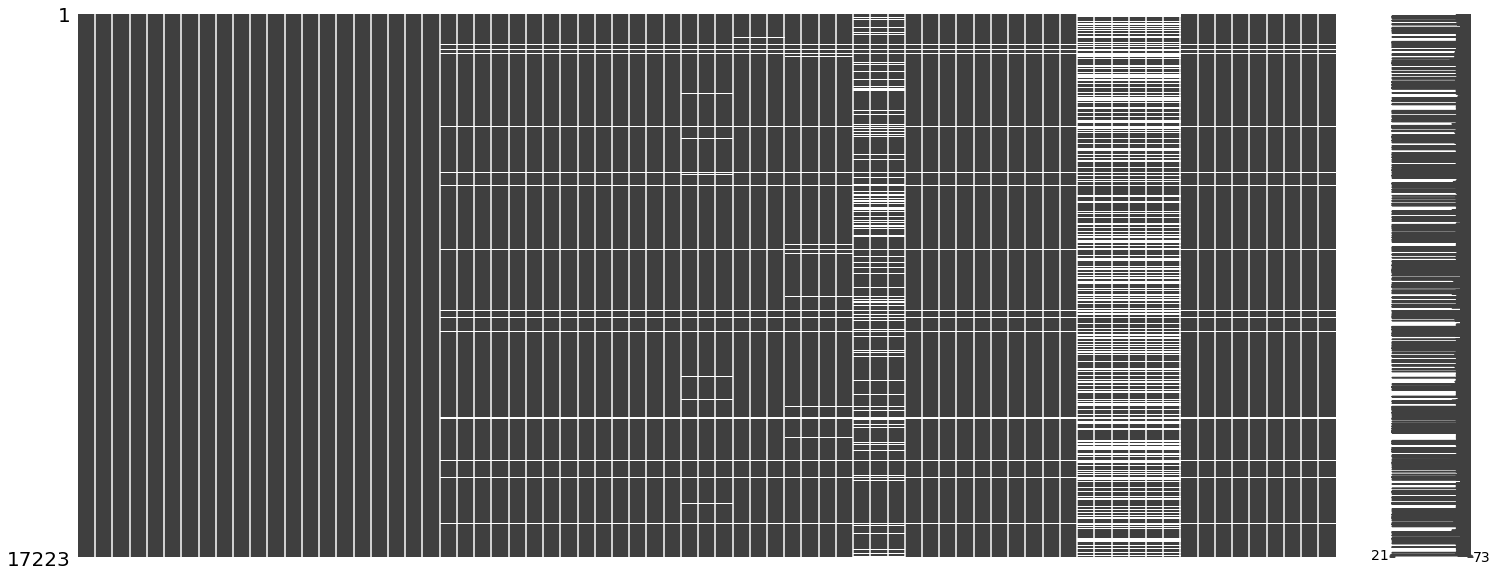

In [3]:
corrupt_5 = pd.read_pickle('corrupt_5')
corrupt_50 = pd.read_pickle('corrupt_50')
clean_5 = pd.read_pickle('clean_5')
clean_50 = pd.read_pickle('clean_50')
msno.matrix(corrupt_50)

In [4]:
df_arr[0].isnull().sum()

HBW              0
HBD              0
Non-HB           0
Peak             0
Off_peak         0
                ..
(3.0, 4.0]      91
(2.0, 99.0]     91
(0.0, 1.0]      91
(1.0, 2.0]      91
(-0.01, 0.0]    91
Length: 73, dtype: int64

In [5]:
corrupt_5 = corrupt_5.replace(np.nan, None)
corrupt_50 = corrupt_50.replace(np.nan, None)



In [ ]:
dsae(df_a, df_dum)

Epoch 1/1000
1082/1082 [==============================] - 2s 2ms/step - loss: 0.3472
Epoch 2/1000
1082/1082 [==============================] - 2s 2ms/step - loss: 0.2392
Epoch 3/1000
1082/1082 [==============================] - 2s 2ms/step - loss: 0.2215
Epoch 4/1000
1082/1082 [==============================] - 2s 2ms/step - loss: 0.2099
Epoch 5/1000
1082/1082 [==============================] - 2s 2ms/step - loss: 0.2051
Epoch 6/1000
1082/1082 [==============================] - 2s 2ms/step - loss: 0.2024
Epoch 7/1000
1082/1082 [==============================] - 2s 2ms/step - loss: 0.2006
Epoch 8/1000
1082/1082 [==============================] - 2s 2ms/step - loss: 0.1992
Epoch 9/1000
1082/1082 [==============================] - 2s 2ms/step - loss: 0.1981
Epoch 10/1000
1082/1082 [==============================] - 2s 2ms/step - loss: 0.1972
Epoch 11/1000
1082/1082 [==============================] - 2s 2ms/step - loss: 0.1965
Epoch 12/1000
1082/1082 [==============================] - 2s 2

In [13]:
def dsae(x_corrupt, x_clean, x_test):
    input_x = keras.Input(shape=(x_corrupt.shape[1],))
    encoded = layers.Dense(int(x_corrupt.shape[1]/8), activation='relu')(input_x)
    #encoded = layers.Dense(int(x_train.shape[0]/6), activation='relu')(encoded)
    #encoded = layers.Dense(int(x_train.shape[0]/8), activation='relu')(encoded)

    #decoded = layers.Dense(int(x_train.shape[0]/8), activation='relu')(encoded)
    #decoded = layers.Dense(int(x_train.shape[0]/6), activation='relu')(decoded)
    decoded = layers.Dense(int(x_corrupt.shape[1]), activation='sigmoid')(encoded)
    
    
    autoencoder = keras.Model(input_x, decoded)
    autoencoder.compile(optimizer='adamax', loss='categorical_crossentropy')
    x_corrupt = x_corrupt
    x_clean = x_clean
    autoencoder.fit(x_corrupt, x_clean,
                    epochs=50,
                    batch_size=32,
                    shuffle=True)
    #x_test = x_test
    return autoencoder.predict(x_test)
 

In [14]:
def svm(x_train, y_nEncode, x_test, y_test, j, acc_np):
    model = SVC()
    model.fit(X = x_train, y = y_nEncode)
    print("test 1")
    y_predict = model.predict(x_test)
    print("test 2")
    print(confusion_matrix(y_test, y_predict))
    print(accuracy_score(y_test,y_predict))
    print(len(y_test))
    acc_np[0][j] += accuracy_score(y_test,y_predict) * len(y_test)
    acc_np[1][j] += len(y_test)
    return acc_np

In [15]:
def mlp(x_train, y_nEncode, x_test, y_test, j, acc_np):
    mlp_clf = MLPClassifier(solver = 'adam', hidden_layer_sizes=(30,30,))
    mlp_clf.fit(x_train, y_nEncode)
    y_pred = mlp_clf.predict(x_test)
    print(accuracy_score(y_test,y_pred))
    print(confusion_matrix(y_test, y_pred))
    acc_np[0][j] += accuracy_score(y_test,y_pred) * len(y_test)
    acc_np[1][j] += len(y_test)
    return acc_np

In [16]:
def mean_imp(df_not_dummy):
    df_freq = df_not_dummy.applymap
    mean_imputer = SimpleImputer(strategy='most_frequent', missing_values='None') # imputing using constant value
    nd = mean_imputer.fit_transform(df_freq)
    return nd

def hot_deck(df_not_dummy):
    df_freq = df_not_dummy.applymap(str)
    knn_imputer = KNNImputer(missing_values = np.nan, n_neighbors =  1)
    nd  = knn_imputer.fit_transform(df_freq)
    return nd

def regress(x_train, y_nEncode, x_test, y_test, j, acc_np):
    model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', n_jobs=-1, max_iter=800, class_weight= 'balanced')

    model.fit(X = x_train, y = y_nEncode)
    y_predict = model.predict(x_test)
    #print(classification_report(y_test, y_predict, digits = 3))
    print(confusion_matrix(y_test, y_predict))
    print(accuracy_score(y_test,y_predict))
    print(len(y_test))
    acc_np[0][j] += accuracy_score(y_test,y_predict) * len(y_test)
    acc_np[1][j] += len(y_test)
    return acc_np
#return y_train, x_train, y_test, x_test, y_predict

In [17]:
def impute(df, index_array, solver, df_mode = None, clean = None, corrupt = None):

    count_array = np.unique(index_array)
    train_encode = not_encode.copy()
    
    index_array2 = np.copy(index_array)
    
    for i in count_array:
        pop_index = np.where(index_array2 == i)[0][-1]
        index_array2 = np.delete(index_array2, pop_index)
    
    
    if solver == 'regress' or solver == 'mlp' or solver == 'svm':
        train_data =  df.copy()

        #train_encode = not_encode.copy()
        is_notNaN = train_data.isnull()
        row_not_NaN = is_notNaN.any(axis = 1)
        row_not_NaN = row_not_NaN.replace([False],'f')
        row_not_NaN = row_not_NaN.replace([True], False)
        row_not_NaN = row_not_NaN.replace(['f'],True)

        train_encode = train_encode[row_not_NaN]
        train_data = train_data.dropna(axis=0)

        test_data = df.copy()


        test_encode = not_encode.copy()

        x_imputed_df = df.copy()

        #x_imputed_df = mean_imputer.fit_transform(x_imputed_df)

        #x_imputed_df = pd.DataFrame(data = x_imputed_df, columns = [j for j in test_data.columns])
    
    
    #print(train_data.shape)
    #print(x_imputed_df.shape)
    
        train_data = train_data.drop([train_data.columns[np.where(index_array == j)[0][-1]] for j in count_array], axis = 1)
        test_data = test_data.drop([test_data.columns[np.where(index_array == j)[0][-1]] for j in count_array], axis = 1)
        #x_imputed_df = x_imputed_df.drop([x_imputed_df.columns[np.where(index_array == j)[0][-1]] for j in count_array], axis = 1)    
    
    #c_report = np.array()
        y_count = 0
        acc_np = np.array([np.zeros(len(train_encode.columns)), np.zeros(len(train_encode.columns))])
        for i in mc:
            print("Missing Combination: {}".format(i))
            y_train = train_data[[train_data.columns[np.where(index_array2 == k)[0][x]] for k in i for x in range(len(np.where(index_array2 == k)[0][:]))]].copy()
            #print(y_train.shape)
            x_train =  train_data[[l for l in train_data.columns if l not in y_train.columns]].copy()
            x_t = test_data[[l for l in test_data.columns if l not in y_train.columns]].copy()
            #print(x_train.shape, x_t.shape)
            x_test = pd.DataFrame(columns = x_train.columns)
            i.sort()
            for k in range(x_t.shape[0]):
                index = np.where(missing_indicies.iloc[k, :].isnull())[0]
                index.sort()
                if len(index) == len(i):
                    if np.array_equal(i, index):
                        x_test = x_test.append(x_t.iloc[k,:], ignore_index = True)
            #print(x_test.isnull().sum().sum())    
            if x_test.shape[0] !=0:
                for j in i:
                    print("Feature: {}".format(train_encode.columns[j]))
                    y_nEncode = train_encode[train_encode.columns[j]].copy()
                    y_t = test_encode[[test_encode.columns[j]]].copy()
                    print(y_t.shape)
                    y_test = pd.DataFrame(columns = [train_encode.columns[j]])
                    #ct = 0
                    y_app = np.array([])
                    for k in range(y_t.shape[0]):
                        index = np.where(missing_indicies.iloc[k, :].isnull())[0]
                        index.sort()
                        if len(index) == len(i):
                            if np.array_equal(i, index):
                            #ct+=1
                            #print(ct)
                            #print(y_t.iat[k,0])
                                y_app = np.append(y_app, y_t.iat[k,0])
                            #y_app = pd.DataFrame(data = y_app, columns = [train_encode.columns[j]])
                            #print('OK')
                    #y_test = y_test.append(y_app, ignore_index = True)
                    y_app = pd.DataFrame(data = y_app, columns = [train_encode.columns[j]])
                    if solver == 'regress':
                        acc_np = regress(x_train, y_nEncode, x_test, y_app, j, acc_np)
                    elif solver == 'svm':
                        acc_np = svm(x_train, y_nEncode, x_test, y_app, j, acc_np)
                    else:
                        acc_np = mlp(x_train, y_nEncode, x_test, y_app, j, acc_np)
            else:
                print('No value for the missing combination found.')
            
            y_count+=1   
        for j in range(len(train_encode.columns)):
            print("{}:{}".format(train_encode.columns[j], acc_np[0][j]/acc_np[1][j]))
                
                
        """for i in count_array:
            y_checkna = df[[df.columns[np.where(index_array2 == i)[0][x]] for x in range(len(np.where(index_array2 == i)[0]))]].copy()
            if y_checkna.isnull().sum().sum() != 0:
                #print(i)
                y_nEncode = train_encode[train_encode.columns[i]].copy()

                y_train = train_data[[train_data.columns[np.where(index_array2 == i)[0][x]] for x in range(len(np.where(index_array2 == i)[0][:]))]].copy()
                #print("Y_train",y_train.shape)
                x_train = train_data[[l for l in train_data.columns if l not in y_train.columns]].copy()
                #rint(x_train.shape)


                y_t = test_data[[test_data.columns[np.where(index_array2 == i)[0][x]] for x in range(len(np.where(index_array2 == i)[0][:]))]].copy()
                #print(y_t.shape)

                x_test =  x_imputed_df[[l for l in x_imputed_df.columns if l not in y_t.columns]].copy()
                #print(x_test.shape)

                y_test = test_encode[test_encode.columns[i]].copy()

                is_NaN = y_t.isnull()
                row_has_NaN = is_NaN.any(axis=1)


                x_test = x_test[row_has_NaN]
                y_test = y_test[row_has_NaN]

                #print(x_test)



                #print(x_test)

                regress(x_train, y_nEncode, x_test, y_test)"""
    elif solver == 'mode' or solver == 'hot deck' or solver == 'dsae':
        if solver == 'mode' or solver == 'hot deck':
            df_mode_impute = df_mode.copy()
            df_h = df.copy()
            df_h = df_h.drop([df_h.columns[np.where(index_array == j)[0][-1]] for j in count_array], axis = 1)
            df_d = df_dum.copy()
            df_d = df_d.drop([df_d.columns[np.where(index_array == j)[0][-1]] for j in count_array], axis = 1)
        if solver == 'dsae':
            df_h = df.copy()
            df_mode_impute = df_mode.copy()
            x_clean = clean.copy()
            x_corrupt = corrupt.copy()
            is_NaN = df_h.isnull().copy()
            row_has_NaN = is_NaN.any(axis=1)
            df_h = df_h[row_has_NaN]
            df_h = df_h.drop([df_h.columns[np.where(index_array == j)[0][-1]] for j in count_array], axis = 1)
            df_d = df_dum.copy()
            df_d = df_d[row_has_NaN]
            df_d = df_d.drop([df_d.columns[np.where(index_array == j)[0][-1]] for j in count_array], axis = 1)
            x_clean = x_clean.drop([x_clean.columns[np.where(index_array == j)[0][-1]] for j in count_array], axis = 1)
            x_corrupt = x_corrupt.drop([x_corrupt.columns[np.where(index_array == j)[0][-1]] for j in count_array], axis = 1)
            df_h = df_h.reset_index(drop=True)
            df_d = df_d.reset_index(drop = True)
            

        
        if solver == 'mode':
            nd = mean_imp(df_mode_impute)
            df_mode_impute = pd.DataFrame(data=nd, columns=df_mode_impute.columns)
            for i in count_array:
                if df_50[df_50.columns[i]].isnull().sum().sum() != 0:
                    is_NaN = df_50[[df_50.columns[i]]].isnull()
                    row_has_NaN = is_NaN.any(axis=1)
                    t = df_mode_impute[row_has_NaN].copy()
                    k = train_encode[row_has_NaN].copy()
                    #print(t[df_mode_impute.columns[i]], k[train_encode.columns[i]])
                    print(classification_report(k[train_encode.columns[i]], t[df_mode_impute.columns[i]], digits = 3))
                    #print(confusion_matrix(train_encode[train_encode.columns[i]], df_mode_impute[df_mode_impute.columns[i]]))
        else:
            if solver == 'hot deck':
                nd = hot_deck(df_h)
                df_H = pd.DataFrame(data=nd, columns=df_h.columns)
                print(df_H.isnull().sum().sum())
            if solver == 'dsae':
                #x_test = df_h.copy().replace(np.nan,0)
                x_test = df_h.copy().replace(np.nan, None)
                nd = dsae(x_corrupt, x_clean, x_test)
                df_H = pd.DataFrame(data = nd, columns=df_h.columns)
                #print(df_H.isnull().sum().sum())
                #print(df_H.round(0))
                df_H = df_H.round(0)
                df_H = df_H.dropna(axis=0)
                df_d = df_d.drop(index = 0)
                print(df_H.head())
                print(df_H.shape, df_d.shape)
            acc = np.array(np.zeros(len(count_array)))
            leng = np.array(np.zeros(len(count_array)))
            for i in range(len(index_array2)):
                if df_h[df_h.columns[i]].isnull().sum().sum() != 0:
                    print(df_mode_impute.columns[index_array2[i]])
                    is_NaN = df_h[[df_h.columns[i]]].isnull().copy()
                    row_has_NaN = is_NaN.any(axis=1)
                    #print(row_has_NaN)
                    t = df_H[row_has_NaN].copy()
                    k = df_d[row_has_NaN].copy()
                    #print(k[df_d.columns[i]].unique())
                    #print(k[df_d.columns[i]].shape[0])
                    cm = confusion_matrix(k[df_d.columns[i]], t[df_H.columns[i]]).ravel()
                    #print(cm[-1:][0])
                    print(confusion_matrix(k[df_d.columns[i]], t[df_H.columns[i]]))
                    #print(index_array2[i])
                    acc[index_array2[i].astype(int)] +=  cm[-1:][0]
                    leng[index_array2[i].astype(int)] = k[df_d.columns[i]].shape[0]
            print(acc/leng)
            #return df_H  

In [18]:
impute(df_arr[-1].copy(), index_array, solver = 'svm', df_mode = df_0 ,clean = clean_5, corrupt = clean_5)

Missing Combination: [14]
Feature: hh_income
(34608, 1)
test 1
test 2
[[ 116   66   93  710    0  430]
 [  18  997  211  450   11   44]
 [  21  482  468  680    4  136]
 [  52  310  255 1810    3  448]
 [   3  219   40   68   76    2]
 [  88   45  120  940    0 1159]]
0.4374468085106383
10575
Missing Combination: [10]
Feature: free_park
(34608, 1)
test 1
test 2
[[  44    0  397]
 [   0 1671    0]
 [  10    0 2160]]
0.904950957496497
4282
Missing Combination: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Feature: age
(34608, 1)
test 1
test 2
[[68  2  3  2  0  5  1  1  2  8]
 [14  9  8  3  8 18  1  7  2  7]
 [12  8 17  8 10 32  0  6  0  5]
 [ 8  4 18 11 10 25  0  4  1  5]
 [ 3  2 15  2  9 20  0  9  1  3]
 [ 6  4 10  7  7 20  1  2  4 12]
 [ 7  1 10  2 12 27  1  7  7  4]
 [ 4  5 12  5 12 20  2 17  7 12]
 [ 2  1  7  2 10 16  0 12  8 15]
 [ 9  0  5  4 10 13  2 15  4 27]]
0.22639225181598063
826
Feature: sex
(34608, 1)
test 1
test 2
[[241 183]
 [205 197]]
0.5302663438256658
826
Feature: driv

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in double_scalars


In [18]:
impute(df_arr[0].copy(), index_array, solver = 'svm', df_mode = df_0 ,clean = clean_5, corrupt = clean_5)

Missing Combination: [14]
Feature: hh_income
(34608, 1)
[[ 13   9   8  50   0  39]
 [  0 133  24  47   6   6]
 [  4  65  72  53   5  15]
 [  1  37  29 163   1  43]
 [  1  17   7   2  22   0]
 [  1   6  14  56   0 102]]
0.4804947668886774
1051
Missing Combination: [10]
Feature: free_park
(34608, 1)
[[  3   0  53]
 [  0 143   0]
 [  2   0 229]]
0.872093023255814
430
Missing Combination: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Feature: age
(34608, 1)
[[4 0 1 0 0 0 0 0 0 1]
 [3 3 0 0 3 1 2 1 1 5]
 [1 0 2 2 0 1 1 0 0 0]
 [0 0 0 0 2 0 0 1 1 2]
 [0 0 2 1 1 0 0 1 1 2]
 [2 1 0 1 1 1 0 0 0 0]
 [1 0 2 1 1 1 0 0 0 2]
 [0 1 0 0 0 1 0 0 2 2]
 [1 0 0 1 1 0 0 0 4 3]
 [2 1 0 0 2 0 0 1 1 8]]
0.25274725274725274
91
Feature: sex
(34608, 1)
[[32 22]
 [17 20]]
0.5714285714285714
91
Feature: driver_lic
(34608, 1)
[[ 2  3]
 [ 3 83]]
0.9340659340659341
91
Feature: tran_pass
(34608, 1)
[[78  1  0]
 [ 9  2  0]
 [ 1  0  0]]
0.8791208791208791
91
Feature: emp_stat
(34608, 1)
[[35 15  0]
 [16 24  0]
 [ 1  0 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in double_scalars


In [18]:
df_H = impute(df_arr[0].copy(), index_array, solver = 'dsae', df_mode = df_0 ,clean = clean_5, corrupt = clean_5)

Epoch 1/50
1027/1027 [==============================] - 2s 2ms/step - loss: 0.4279
Epoch 2/50
1027/1027 [==============================] - 2s 2ms/step - loss: 0.3152
Epoch 3/50
1027/1027 [==============================] - 2s 2ms/step - loss: 0.2708
Epoch 4/50
1027/1027 [==============================] - 2s 2ms/step - loss: 0.2473
Epoch 5/50
1027/1027 [==============================] - 2s 2ms/step - loss: 0.2364
Epoch 6/50
1027/1027 [==============================] - 2s 2ms/step - loss: 0.2300
Epoch 7/50
1027/1027 [==============================] - 2s 2ms/step - loss: 0.2257
Epoch 8/50
1027/1027 [==============================] - 2s 2ms/step - loss: 0.2224
Epoch 9/50
1027/1027 [==============================] - 2s 2ms/step - loss: 0.2199
Epoch 10/50
1027/1027 [==============================] - 2s 2ms/step - loss: 0.2178
Epoch 11/50
1027/1027 [==============================] - 2s 2ms/step - loss: 0.2162
Epoch 12/50
1027/1027 [==============================] - 2s 2ms/step - loss: 0.2149
E

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:195: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:196: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ValueError: Found input variables with inconsistent numbers of samples: [1272, 1265]

In [15]:
#binary cross entropy
df_H = impute(df_arr[-1].copy(), index_array, solver = 'dsae', df_mode = df_50 ,clean = clean_50, corrupt = corrupt_50)

Epoch 1/50
539/539 [==============================] - 1s 2ms/step - loss: 0.4796
Epoch 2/50
539/539 [==============================] - 1s 2ms/step - loss: 0.3673
Epoch 3/50
539/539 [==============================] - 1s 2ms/step - loss: 0.3256
Epoch 4/50
539/539 [==============================] - 1s 2ms/step - loss: 0.2974
Epoch 5/50
539/539 [==============================] - 1s 2ms/step - loss: 0.2795
Epoch 6/50
539/539 [==============================] - 1s 2ms/step - loss: 0.2682
Epoch 7/50
539/539 [==============================] - 1s 2ms/step - loss: 0.2603
Epoch 8/50
539/539 [==============================] - 1s 3ms/step - loss: 0.2548
Epoch 9/50
539/539 [==============================] - 1s 2ms/step - loss: 0.2508
Epoch 10/50
539/539 [==============================] - 1s 2ms/step - loss: 0.2479
Epoch 11/50
539/539 [==============================] - 1s 2ms/step - loss: 0.2456
Epoch 12/50
539/539 [==============================] - 1s 2ms/step - loss: 0.2436
Epoch 13/50
539/539 [====

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:195: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:196: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[[5341  143]
 [ 427  173]]
free_park
[[3512  119]
 [ 108 2345]]
stu_stat
[[ 61  65]
 [ 34 666]]
n_pers_trip
[[420  85]
 [129 192]]
n_pers_trip
[[748   0]
 [ 78   0]]
n_pers_trip
[[533  89]
 [ 93 111]]
n_pers_trip
[[640  54]
 [ 59  73]]
hh_dwell_type
[[658  49]
 [ 67  52]]
hh_dwell_type
[[ 89 119]
 [ 66 552]]
hh_income
[[10796    13]
 [ 1665     6]]
hh_income
[[10018   461]
 [ 1528   473]]
hh_income
[[10276    83]
 [ 2100    21]]
hh_income
[[9086    0]
 [3394    0]]
hh_income
[[12016    10]
 [  447     7]]
hh_size
[[679  41]
 [ 63  43]]
hh_size
[[418  95]
 [ 65 248]]
hh_size
[[673  10]
 [114  29]]
hh_size
[[611  35]
 [ 47 133]]
hh_n_vehs
[[801   3]
 [ 18   4]]
hh_n_vehs
[[493  81]
 [ 73 179]]
hh_n_vehs
[[353  72]
 [ 76 325]]
[       nan        nan        nan        nan 0.11138015 0.30508475
 0.05298651 0.93267652 0.73014019 0.55431755 0.41387245 0.8062954
 0.45520581 0.73123487 0.040625   0.54842615 0.61501211]


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in true_divide


In [20]:
#cosine
df_H = impute(df_arr[-1].copy(), index_array, solver = 'dsae', df_mode = df_50 ,clean = clean_50, corrupt = corrupt_50)

Epoch 1/50
539/539 [==============================] - 1s 2ms/step - loss: -0.6030
Epoch 2/50
539/539 [==============================] - 1s 2ms/step - loss: -0.7081
Epoch 3/50
539/539 [==============================] - 1s 2ms/step - loss: -0.7560
Epoch 4/50
539/539 [==============================] - 1s 2ms/step - loss: -0.7893
Epoch 5/50
539/539 [==============================] - 1s 2ms/step - loss: -0.8046
Epoch 6/50
539/539 [==============================] - 1s 3ms/step - loss: -0.8127
Epoch 7/50
539/539 [==============================] - 1s 2ms/step - loss: -0.8187
Epoch 8/50
539/539 [==============================] - 1s 2ms/step - loss: -0.8234
Epoch 9/50
539/539 [==============================] - 1s 2ms/step - loss: -0.8272
Epoch 10/50
539/539 [==============================] - 1s 2ms/step - loss: -0.8303
Epoch 11/50
539/539 [==============================] - 1s 3ms/step - loss: -0.8329
Epoch 12/50
539/539 [==============================] - 1s 3ms/step - loss: -0.8353
Epoch 13/50
5

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:195: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:196: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[[5331  153]
 [ 413  187]]
free_park
[[3509  122]
 [ 100 2353]]
stu_stat
[[ 60  66]
 [ 37 663]]
n_pers_trip
[[410  95]
 [120 201]]
n_pers_trip
[[748   0]
 [ 78   0]]
n_pers_trip
[[577  45]
 [158  46]]
n_pers_trip
[[633  61]
 [ 57  75]]
hh_dwell_type
[[655  52]
 [ 61  58]]
hh_dwell_type
[[ 85 123]
 [ 54 564]]
hh_income
[[10528   281]
 [ 1422   249]]
hh_income
[[9948  531]
 [1486  515]]
hh_income
[[10346    13]
 [ 2121     0]]
hh_income
[[9086    0]
 [3394    0]]
hh_income
[[11969    57]
 [  417    37]]
hh_size
[[683  37]
 [ 62  44]]
hh_size
[[414  99]
 [ 67 246]]
hh_size
[[675   8]
 [137   6]]
hh_size
[[612  34]
 [ 44 136]]
hh_n_vehs
[[799   5]
 [ 16   6]]
hh_n_vehs
[[495  79]
 [ 72 180]]
hh_n_vehs
[[355  70]
 [ 73 328]]
[       nan        nan        nan        nan 0.07627119 0.38014528
 0.04816956 0.93924466 0.73481308 0.55988858 0.41748849 0.80266344
 0.38983051 0.75302663 0.06418269 0.52300242 0.62227603]


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in true_divide


In [22]:
#cat_hinge
df_H = impute(df_arr[-1].copy(), index_array, solver = 'dsae', df_mode = df_50 ,clean = clean_50, corrupt = corrupt_50)

Epoch 1/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Epoch 2/50
539/539 [==============================] - 2s 3ms/step - loss: 0.0000e+00
Epoch 3/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Epoch 4/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Epoch 5/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Epoch 6/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Epoch 7/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Epoch 8/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Epoch 9/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Epoch 10/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Epoch 11/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Epoch 12/50
539/539 [==============================] - 1s 2ms/s

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:195: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:196: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[[5182  302]
 [ 576   24]]
free_park
[[  94 3537]
 [ 247 2206]]
stu_stat
[[ 71  55]
 [447 253]]
n_pers_trip
[[175 330]
 [ 79 242]]
n_pers_trip
[[295 453]
 [ 38  40]]
n_pers_trip
[[389 233]
 [136  68]]
n_pers_trip
[[ 78 616]
 [ 26 106]]
hh_dwell_type
[[ 95 612]
 [ 27  92]]
hh_dwell_type
[[201   7]
 [600  18]]
hh_income
[[8212 2597]
 [1242  429]]
hh_income
[[7742 2737]
 [1222  779]]
hh_income
[[9826  533]
 [2005  116]]
hh_income
[[1667 7419]
 [ 587 2807]]
hh_income
[[2423 9603]
 [ 188  266]]
hh_size
[[530 190]
 [ 81  25]]
hh_size
[[248 265]
 [103 210]]
hh_size
[[679   4]
 [139   4]]
hh_size
[[231 415]
 [ 86  94]]
hh_n_vehs
[[799   5]
 [ 21   1]]
hh_n_vehs
[[263 311]
 [121 131]]
hh_n_vehs
[[138 287]
 [226 175]]
[       nan        nan        nan        nan 0.29418886 0.46610169
 0.07803468 0.80623974 0.73014019 0.35097493 0.36653517 0.3062954
 0.55205811 0.13317191 0.35232372 0.4031477  0.3716707 ]


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in true_divide


In [26]:
df_H = impute(df_arr[-1].copy(), index_array, solver = 'dsae', df_mode = df_50 ,clean = clean_50, corrupt = corrupt_50)

Epoch 1/50
539/539 [==============================] - 1s 2ms/step - loss: 48.6850
Epoch 2/50
539/539 [==============================] - 1s 2ms/step - loss: 45.2426
Epoch 3/50
539/539 [==============================] - 1s 2ms/step - loss: 43.8755
Epoch 4/50
539/539 [==============================] - 1s 2ms/step - loss: 42.9294
Epoch 5/50
539/539 [==============================] - 1s 2ms/step - loss: 42.3175
Epoch 6/50
539/539 [==============================] - 1s 2ms/step - loss: 41.9580
Epoch 7/50
539/539 [==============================] - 1s 2ms/step - loss: 41.7143
Epoch 8/50
539/539 [==============================] - 1s 2ms/step - loss: 41.5337
Epoch 9/50
539/539 [==============================] - 1s 2ms/step - loss: 41.3940
Epoch 10/50
539/539 [==============================] - 1s 2ms/step - loss: 41.2817
Epoch 11/50
539/539 [==============================] - 1s 2ms/step - loss: 41.1895
Epoch 12/50
539/539 [==============================] - 1s 2ms/step - loss: 41.1152
Epoch 13/50
5

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:195: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:196: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[[5347  137]
 [ 437  163]]
free_park
[[3515  116]
 [ 150 2303]]
stu_stat
[[ 63  63]
 [ 50 650]]
n_pers_trip
[[411  94]
 [129 192]]
n_pers_trip
[[744   4]
 [ 77   1]]
n_pers_trip
[[544  78]
 [150  54]]
n_pers_trip
[[651  43]
 [100  32]]
hh_dwell_type
[[650  57]
 [ 67  52]]
hh_dwell_type
[[ 82 126]
 [ 65 553]]
hh_income
[[10770    39]
 [ 1657    14]]
hh_income
[[9802  677]
 [1415  586]]
hh_income
[[9949  410]
 [2032   89]]
hh_income
[[9086    0]
 [3394    0]]
hh_income
[[11986    40]
 [  412    42]]
hh_size
[[682  38]
 [ 66  40]]
hh_size
[[416  97]
 [ 88 225]]
hh_size
[[672  11]
 [141   2]]
hh_size
[[608  38]
 [ 55 125]]
hh_n_vehs
[[797   7]
 [ 17   5]]
hh_n_vehs
[[495  79]
 [ 81 171]]
hh_n_vehs
[[347  78]
 [ 88 313]]
[       nan        nan        nan        nan 0.19975787 0.28813559
 0.04624277 0.94006568 0.72780374 0.53017642 0.40532544 0.78692494
 0.3377724  0.73244552 0.05857372 0.47457627 0.59200969]


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in true_divide


In [16]:
df_H = impute(df_arr[-1].copy(), index_array, solver = 'dsae', df_mode = df_50 ,clean = clean_50, corrupt = clean_50)

Epoch 1/50
539/539 [==============================] - 1s 2ms/step - loss: 0.4884
Epoch 2/50
539/539 [==============================] - 1s 2ms/step - loss: 0.3665
Epoch 3/50
539/539 [==============================] - 1s 2ms/step - loss: 0.3244
Epoch 4/50
539/539 [==============================] - 1s 2ms/step - loss: 0.2949
Epoch 5/50
539/539 [==============================] - 1s 2ms/step - loss: 0.2741
Epoch 6/50
539/539 [==============================] - 1s 2ms/step - loss: 0.2602
Epoch 7/50
539/539 [==============================] - 1s 2ms/step - loss: 0.2507
Epoch 8/50
539/539 [==============================] - 2s 4ms/step - loss: 0.2441
Epoch 9/50
539/539 [==============================] - 1s 2ms/step - loss: 0.2394
Epoch 10/50
539/539 [==============================] - 1s 2ms/step - loss: 0.2359
Epoch 11/50
539/539 [==============================] - 1s 2ms/step - loss: 0.2332
Epoch 12/50
539/539 [==============================] - 1s 2ms/step - loss: 0.2311
Epoch 13/50
539/539 [====

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:195: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:196: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[[5319  165]
 [ 410  190]]
free_park
[[3488  143]
 [ 148 2305]]
stu_stat
[[ 58  68]
 [ 40 660]]
n_pers_trip
[[415  90]
 [119 202]]
n_pers_trip
[[748   0]
 [ 78   0]]
n_pers_trip
[[569  53]
 [143  61]]
n_pers_trip
[[660  34]
 [ 94  38]]
hh_dwell_type
[[642  65]
 [ 61  58]]
hh_dwell_type
[[ 97 111]
 [ 69 549]]
hh_income
[[10023   786]
 [ 1066   605]]
hh_income
[[9856  623]
 [1434  567]]
hh_income
[[9498  861]
 [1626  495]]
hh_income
[[7600 1486]
 [1836 1558]]
hh_income
[[11983    43]
 [  431    23]]
hh_size
[[674  46]
 [ 66  40]]
hh_size
[[418  95]
 [ 67 246]]
hh_size
[[683   0]
 [143   0]]
hh_size
[[610  36]
 [ 43 137]]
hh_n_vehs
[[797   7]
 [ 16   6]]
hh_n_vehs
[[502  72]
 [ 74 178]]
hh_n_vehs
[[351  74]
 [ 74 327]]
[       nan        nan        nan        nan 0.06779661 0.34503632
 0.04913295 0.93678161 0.73130841 0.53946147 0.41009204 0.79903148
 0.36440678 0.73486683 0.26025641 0.51210654 0.61864407]


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in true_divide


In [25]:
impute(df_arr[0].copy(), index_array, 'mlp')

Missing Combination: [14]
Feature: hh_income
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.45670789724072314
[[ 14  10   7  55   0  33]
 [  1 136  23  43   4   9]
 [  2  64  74  54  11   9]
 [  7  44  37 132   3  51]
 [  1  14   5   3  26   0]
 [ 13   8  12  48   0  98]]
Missing Combination: [10]
Feature: free_park
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.9093023255813953
[[ 33   0  23]
 [  0 143   0]
 [ 16   0 215]]
Missing Combination: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Feature: age
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.21978021978021978
[[4 0 0 0 0 1 0 0 0 1]
 [2 3 0 0 6 1 2 1 1 3]
 [1 0 1 2 0 1 2 0 0 0]
 [0 0 0 0 3 0 1 0 1 1]
 [0 0 0 1 1 2 0 2 1 1]
 [2 0 1 0 1 2 0 0 0 0]
 [1 1 0 1 1 3 0 0 0 1]
 [0 2 0 0 0 0 0 1 2 1]
 [1 0 0 0 1 1 0 0 4 3]
 [3 1 0 0 3 2 0 1 1 4]]
Feature: sex
(34608, 1)
0.5604395604395604
[[31 23]
 [17 20]]
Feature: driver_lic
(34608, 1)
0.945054945054945
[[ 2  3]
 [ 2 84]]
Feature: tran_pass
(34608, 1)
0.8791208791208791
[[78  1  0]
 [ 9  2  0]
 [ 1  0  0]]
Feature: emp_stat
(34608, 1)
0.6703296703296703
[[38 12  0]
 [17 23  0]
 [ 1  0  0]]
Feature: occupation
(34608, 1)
0.5274725274725275
[[19  0 10  0]
 [ 5  0  1  0]
 [13  0 27  0]
 [ 8  0  6  2]]
Feature: free_park
(34608, 1)
0.6263736263736264
[[ 0  3  5]
 [ 0 28 12]
 [ 0 14 29]]
Feature: stu_stat
(34608, 1)
0.8791208791208791
[[72  3]
 [ 8  8]]
Feature: n_pers_trip
(34608, 1)
0.32967032967032966
[[15  0  8  2  0]
 [ 3  0  5  0  0]
 [16  0 15  1  0]
 [ 2  0 18  0  1]
 [ 1  0  3  1  0]]
Feature: hh_dwell_type
(34608, 1)
0.65934

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.96
[[23  0]
 [ 1  1]]
Missing Combination: [10, 14]
Feature: free_park
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8869565217391304
[[ 2  0 10]
 [ 0 43  0]
 [ 3  0 57]]
Feature: hh_income
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.4608695652173913
[[ 1  1  1  4  0  5]
 [ 1  9  9  3  0  1]
 [ 0  4 12  3  1  5]
 [ 0  5  2 12  0  8]
 [ 0  2  0  0  2  0]
 [ 0  0  4  3  0 17]]
Missing Combination: [9]
Feature: occupation
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1.0
[[1 0]
 [0 8]]
Missing Combination: [6, 7, 14]
Feature: driver_lic
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1.0
[[1]]
Feature: tran_pass
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1.0
[[1]]
Feature: hh_income
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.0
[[0 1]
 [0 0]]
Missing Combination: [7, 10]
Feature: tran_pass
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1.0
[[4]]
Feature: free_park
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1.0
[[2 0]
 [0 2]]
Missing Combination: [7, 14]
Feature: tran_pass
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1.0
[[9]]
Feature: hh_income
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.6666666666666666
[[1 1 0 1 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 2 0]
 [0 0 0 0 2]]
Missing Combination: [6]
Feature: driver_lic
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1.0
[[8]]
Missing Combination: [9, 10]
Feature: occupation
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.5
[[0 0 0]
 [0 1 0]
 [1 0 0]]
Feature: free_park
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.5
[[0 0 1]
 [0 1 0]
 [0 0 0]]
Missing Combination: [7, 9, 10, 14]
No value for the missing combination found.
Missing Combination: [7, 9, 14]
No value for the missing combination found.
Missing Combination: [9, 14]
Feature: occupation
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1.0
[[1 0]
 [0 1]]
Feature: hh_income
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.0
[[0 1 0]
 [0 0 0]
 [1 0 0]]
Missing Combination: [8]
Feature: emp_stat
(34608, 1)
1.0
[[5 0]
 [0 2]]
Missing Combination: [7, 10, 14]
Feature: tran_pass
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1.0
[[1]]
Feature: free_park
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.0
[[0 1]
 [0 0]]
Feature: hh_income
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.0
[[0 0]
 [1 0]]
Missing Combination: [9, 10, 14]
No value for the missing combination found.
Missing Combination: [8, 14]
No value for the missing combination found.
Missing Combination: [6, 10]
Feature: driver_lic
(34608, 1)
1.0
[[2]]
Feature: free_park
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1.0
[[2]]
Missing Combination: [6, 14]
Feature: driver_lic
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1.0
[[3]]
Feature: hh_income
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.6666666666666666
[[1 1 0]
 [0 0 0]
 [0 0 1]]
Missing Combination: [6, 7]
Feature: driver_lic
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1.0
[[1]]
Feature: tran_pass
(34608, 1)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1.0
[[1]]
Missing Combination: [6, 10, 14]
No value for the missing combination found.
Missing Combination: [6, 7, 10, 14]
No value for the missing combination found.
Missing Combination: [6, 7, 10]
No value for the missing combination found.
Missing Combination: [6, 9]
No value for the missing combination found.
trip_purp:nan
start_time:nan
mode_prime:nan
trip_man_km:nan
age:0.21978021978021978
sex:0.5604395604395604
driver_lic:0.9528301886792453
tran_pass:0.9090909090909091
emp_stat:0.6938775510204082
occupation:0.5769230769230769
free_park:0.8635658914728682
stu_stat:0.8791208791208791
n_pers_trip:0.32967032967032966
hh_dwell_type:0.6593406593406593
hh_income:0.4422623723487824
hh_size:0.42857142857142855
hh_n_vehs:0.37362637362637363


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in double_scalars


In [53]:
impute(df_arr[0].copy(), index_array, 'hot deck')

0
age
[[75 10]
 [ 2  4]]
age
[[63  9]
 [17  2]]
age
[[80  4]
 [ 7  0]]
age
[[84  1]
 [ 6  0]]
age
[[72 11]
 [ 8  0]]
age
[[74 11]
 [ 6  0]]
age
[[79  4]
 [ 8  0]]
age
[[82  3]
 [ 6  0]]
age
[[73  8]
 [10  0]]
sex
[[21 16]
 [32 22]]
driver_lic
[[91 10]
 [ 2  3]]
tran_pass
[[  4  10]
 [  7 111]]
tran_pass
[[112   7]
 [  9   4]]
emp_stat
[[25 18]
 [16 39]]
emp_stat
[[39 17]
 [18 24]]
occupation
[[49 25]
 [16 14]]
occupation
[[89  8]
 [ 6  1]]
occupation
[[37 17]
 [18 32]]
free_park
[[537  30]
 [ 30  48]]
free_park
[[399  17]
 [ 18 211]]
stu_stat
[[ 9  7]
 [13 62]]
n_pers_trip
[[45 21]
 [13 12]]
n_pers_trip
[[76  7]
 [ 8  0]]
n_pers_trip
[[47 12]
 [25  7]]
n_pers_trip
[[62  8]
 [15  6]]
hh_dwell_type
[[58 13]
 [20  0]]
hh_dwell_type
[[ 9 22]
 [18 42]]
hh_income
[[1051   76]
 [  56   90]]
hh_income
[[946  71]
 [ 81 175]]
hh_income
[[924  87]
 [ 98 164]]
hh_income
[[837 105]
 [125 206]]
hh_income
[[1191   25]
 [  17   40]]
hh_size
[[71  2]
 [17  1]]
hh_size
[[36 17]
 [26 12]]
hh_size
[[50 29

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:177: RuntimeWarning: invalid value encountered in true_divide


,HBW,HBD,Peak,Drive,Other,Passenger,Transit,Walk,"(2.0, 3.0]_x","(11.0, 16.0]",...,100k-124k,60k-99k,15k-39k,"(4.0, 9.0]","(1.0, 2.0]_y","(2.0, 3.0]","(0.99, 1.0]","(2.0, 99.0]","(0.0, 1.0]","(1.0, 2.0]"
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34603,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
34604,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
34605,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
34606,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [33]:
msno.matrix(corrupt_50)

NameError: name 'msno' is not defined

In [20]:
count_array = np.unique(index_array)
index_array2 = np.copy(index_array)
for i in count_array:
    pop_index = np.where(index_array2 == i)[0][-1]
    index_array2 = np.delete(index_array2, pop_index)
df_h  = df_arr[-1].copy()
df_h = df_h.drop([df_h.columns[np.where(index_array == j)[0][-1]] for j in count_array], axis = 1)
df_d = df_dum.copy()
df_d = df_d.drop([df_d.columns[np.where(index_array == j)[0][-1]] for j in count_array], axis = 1)
df_mode_impute = df_50.copy()

In [45]:
acc = np.array(np.zeros(len(count_array)))
leng = np.array(np.zeros(len(count_array)))
for i in range(len(index_array2)):
    if df_h[df_h.columns[i]].isnull().sum().sum() != 0:
        print(df_mode_impute.columns[index_array2[i]])
        is_NaN = df_h[[df_h.columns[i]]].isnull().copy()
        row_has_NaN = is_NaN.any(axis=1)
        t = df_H[row_has_NaN].copy()
        k = df_d[row_has_NaN].copy()
        #print(k[df_d.columns[i]].unique())
        #print(k[df_d.columns[i]].shape[0])
        cm = confusion_matrix(k[df_d.columns[i]], t[df_H.columns[i]]).ravel()
        #print(cm[-1:][0])
        print(confusion_matrix(k[df_d.columns[i]], t[df_H.columns[i]]))
        #print(index_array2[i])
        acc[index_array2[i].astype(int)] +=  cm[-1:][0]
        leng[index_array2[i].astype(int)] = k[df_d.columns[i]].shape[0]

age
[[651  83]
 [ 34  58]]
age
[[666  83]
 [ 66  11]]
age
[[720   8]
 [ 95   3]]
age
[[728  12]
 [ 84   2]]
age
[[677  85]
 [ 53  11]]
age
[[676  77]
 [ 68   5]]
age
[[679  69]
 [ 71   7]]
age
[[701  29]
 [ 92   4]]
age
[[681  72]
 [ 65   8]]
sex
[[223 179]
 [224 200]]
driver_lic
[[874  57]
 [ 45  62]]
tran_pass
[[  47   36]
 [ 100 1035]]
tran_pass
[[1040  103]
 [  32   43]]
emp_stat
[[189 160]
 [168 339]]
emp_stat
[[353 172]
 [147 184]]
occupation
[[495 176]
 [222 184]]
occupation
[[919  71]
 [ 60  27]]
occupation
[[468 172]
 [147 290]]
free_park
[[5200  284]
 [ 198  402]]
free_park
[[3470  161]
 [ 152 2301]]
stu_stat
[[ 77  49]
 [151 549]]
n_pers_trip
[[325 180]
 [163 158]]
n_pers_trip
[[713  35]
 [ 74   4]]
n_pers_trip
[[493 129]
 [170  34]]
n_pers_trip
[[644  50]
 [118  14]]
hh_dwell_type
[[584 123]
 [ 85  34]]
hh_dwell_type
[[ 72 136]
 [182 436]]
hh_income
[[9915  895]
 [ 828  843]]
hh_income
[[9693  787]
 [ 828 1173]]
hh_income
[[9303 1056]
 [ 967 1155]]
hh_income
[[7763 1324]
 [

In [46]:
acc

array([   0.,    0.,    0.,    0.,  109.,  200.,   62., 1078.,  523.,
        501., 2703.,  549.,  210.,  470., 5413.,  208.,  287.])

In [47]:
leng

array([    0.,     0.,     0.,     0.,   826.,   826.,  1038.,  1218.,
         856.,  1077.,  6084.,   826.,   826.,   826., 12481.,   826.,
         826.])

In [49]:
acc/leng

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([       nan,        nan,        nan,        nan, 0.13196126,
       0.24213075, 0.05973025, 0.88505747, 0.61098131, 0.46518106,
       0.44428008, 0.66464891, 0.25423729, 0.56900726, 0.43369922,
       0.25181598, 0.34745763])

In [50]:
df_mode_impute.columns

Index(['trip_purp', 'start_time', 'mode_prime', 'trip_man_km', 'age', 'sex',
       'driver_lic', 'tran_pass', 'emp_stat', 'occupation', 'free_park',
       'stu_stat', 'n_pers_trip', 'hh_dwell_type', 'hh_income', 'hh_size',
       'hh_n_vehs'],
      dtype='object')